In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools import load_YAG_events, load_YAG_pulseID
from alvra_tools import errfunc

In [3]:
scan_name ="CA_YAG_NPP_ATT08_YAG20_011"

DIR = "/sf/alvra/data/p17589/res/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17589/res/scan_info/"

In [4]:
json_file = DIR_json + scan_name + "_scan_info.json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")
print (json_file)

Pump_probe = []
err_pump_probe =[]
Delay_mm = []

Izero_FEL_mean = []
err_Izero_FEL_mean = []
Izero_FEL_all = []
Izero_FEL_all_filter = []

PIPS_mean = []
BAM_mean = []
BAM_error = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)

    if (exists):
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, BAM, pids_loop) = \
        load_YAG_events(str(data['scan_files'][i][0]))
        
        threshold_FEL = Izero_FEL > 0.1
        condition_FEL = Izero_FEL > np.median(Izero_FEL)-2*(np.std(Izero_FEL))
        condition_laser_pump = Laser_pump > 10
        condition_laser_unpump = Laser_unpump > 10

        Laser_pump = Laser_pump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Laser_unpump = Laser_unpump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Laser_ref_pump = Laser_ref_pump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Laser_ref_unpump = Laser_ref_unpump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Izero_FEL_filter = Izero_FEL[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        
        Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump))
#        Laser_diff_loop = -np.log10((Laser_pump_loop) / (Laser_unpump_loop))#/Izero_pump_loop_filter
        Pump_probe.append(Laser_diff.mean())
        err_pump_probe.append(Laser_diff.std() / np.sqrt(Laser_diff.size))
        
        Izero_FEL_all.append(Izero_FEL)
        Izero_FEL_all_filter.append(Izero_FEL_filter)
        
        Izero_FEL_mean.append(Izero_FEL.mean())
        err_Izero_FEL_mean.append(Izero_FEL.std() / np.sqrt(Izero_FEL.size))
        
        PIPS_mean.append(PIPS.mean())
        #Delay_mm.append(delay.mean())
        Delay_mm.append(delay[0])
        BAM_mean.append(BAM.mean())
        BAM_error.append(BAM.std() / np.sqrt(BAM.size))
        
Pump_probe = np.asarray(Pump_probe)
err_pump_probe = np.asarray(err_pump_probe)

Izero_FEL_mean = np.asarray(Izero_FEL_mean)
err_Izero_FEL_mean = np.asarray(err_Izero_FEL_mean)

Delay_mm = np.asarray(Delay_mm)
BAM_mean = np.asarray(BAM_mean)
BAM_error = np.asarray(BAM_error)

Processing 31 files
/sf/alvra/data/p17589/res/scan_info/CA_YAG_NPP_ATT08_YAG20_011_scan_info.json
step 1 of 31 : Processing /sf/alvra/data/p17589/res/scan_data/CA_YAG_NPP_ATT08_YAG20_011/CA_YAG_NPP_ATT08_YAG20_011_step0000.h5
step 2 of 31 : Processing /sf/alvra/data/p17589/res/scan_data/CA_YAG_NPP_ATT08_YAG20_011/CA_YAG_NPP_ATT08_YAG20_011_step0001.h5
step 3 of 31 : Processing /sf/alvra/data/p17589/res/scan_data/CA_YAG_NPP_ATT08_YAG20_011/CA_YAG_NPP_ATT08_YAG20_011_step0002.h5
step 4 of 31 : Processing /sf/alvra/data/p17589/res/scan_data/CA_YAG_NPP_ATT08_YAG20_011/CA_YAG_NPP_ATT08_YAG20_011_step0003.h5
step 5 of 31 : Processing /sf/alvra/data/p17589/res/scan_data/CA_YAG_NPP_ATT08_YAG20_011/CA_YAG_NPP_ATT08_YAG20_011_step0004.h5
step 6 of 31 : Processing /sf/alvra/data/p17589/res/scan_data/CA_YAG_NPP_ATT08_YAG20_011/CA_YAG_NPP_ATT08_YAG20_011_step0005.h5
step 7 of 31 : Processing /sf/alvra/data/p17589/res/scan_data/CA_YAG_NPP_ATT08_YAG20_011/CA_YAG_NPP_ATT08_YAG20_011_step0006.h5
step 8

Total shots= 7750 // filtered=, 7455


<IPython.core.display.Javascript object>


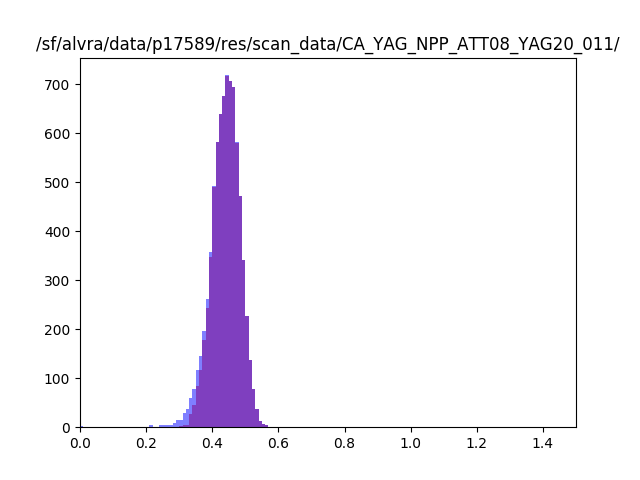

In [5]:
# Check if the condition on the intensity makes sense by looking at the total histogram. 

Izero_total_1D = np.hstack(Izero_FEL_all)
Izero_total_1D_filter = np.hstack(Izero_FEL_all_filter)

print ("Total shots=",Izero_total_1D.size,"// filtered=,",Izero_total_1D_filter.size)
plt.figure()

### ALL STEPS ###
plt.hist(Izero_total_1D_filter, bins = np.arange(0,1.5,0.01), facecolor='red', alpha=0.5)
plt.hist(Izero_total_1D, bins = np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)

### ONLY THE LAST STEP ###
#plt.hist(Izero_FEL, bins = np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_FEL_filter, bins = np.arange(0,1.5,0.01), facecolor='orange', alpha=0.5)

plt.xlim(0,1.5)
plt.title(DIR)

plt.show()

<IPython.core.display.Javascript object>


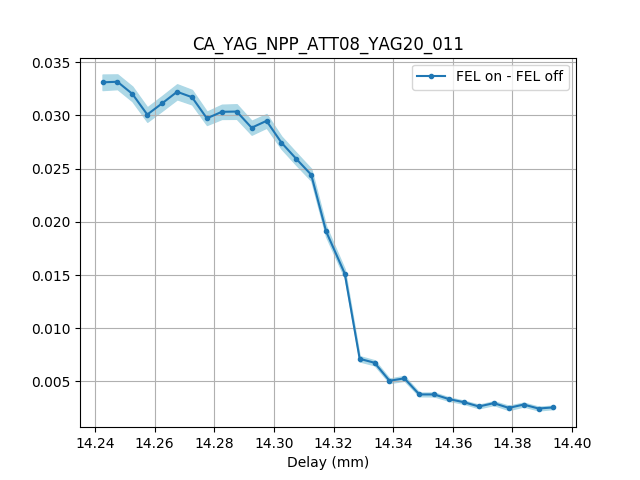

In [6]:
# Plot pump probe signal as a function of delay (stage mm)

#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure()
plt.plot(Delay_mm, Pump_probe, label="FEL on - FEL off",marker='.')

low_err = Pump_probe - err_pump_probe
high_err = Pump_probe + err_pump_probe
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

plt.title(scan_name)
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig(savedir + 'LAMcheck_026')

<IPython.core.display.Javascript object>


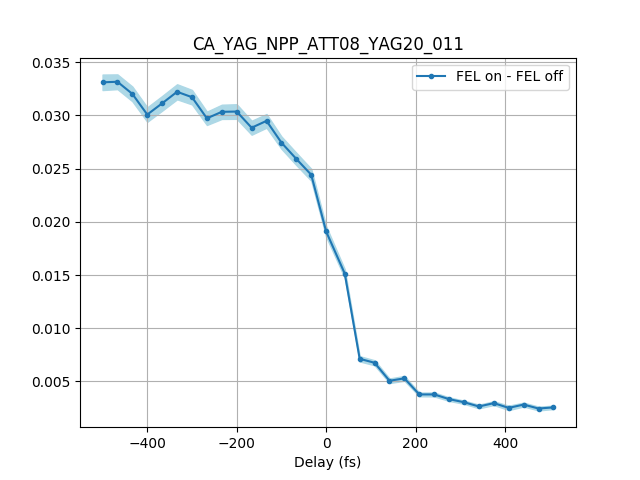

In [7]:
# Plot pump probe signal as a function of time (fs)

#savedir = "/das/work/p17/p17569/Beamline/"

Delay_ps = 2* (Delay_mm - 14.3175)*3.333   # factor of 2 in delay due to the delay stage

plt.figure()
plt.plot((Delay_ps)*1000, Pump_probe, label="FEL on - FEL off",marker='.')   

low_err = Pump_probe - err_pump_probe
high_err = Pump_probe + err_pump_probe
plt.fill_between(np.squeeze((Delay_ps)*1000), low_err, high_err, color='lightblue')

plt.title(scan_name)
plt.xlabel("Delay (fs)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig('Timescan_7_diode')

In [8]:
#RUN THIS FOR THE FIT !!!

Delay_mm_toFit = Delay_mm.copy()
Delay_ps_toFit = Delay_ps.copy()
Pump_probe_toFit = Pump_probe.copy()

In [9]:
# Now fit with error funciton (defined above)
parameters,extras = curve_fit(errfunc, Delay_ps_toFit, Pump_probe_toFit, p0 = [0.02, 1, 0, 0.05])

print("Position t0 =",np.round(parameters[2],5)*1000,"fs")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"fs")

Position t0 = 14.22 fs
Width = 210.0 fs


<IPython.core.display.Javascript object>


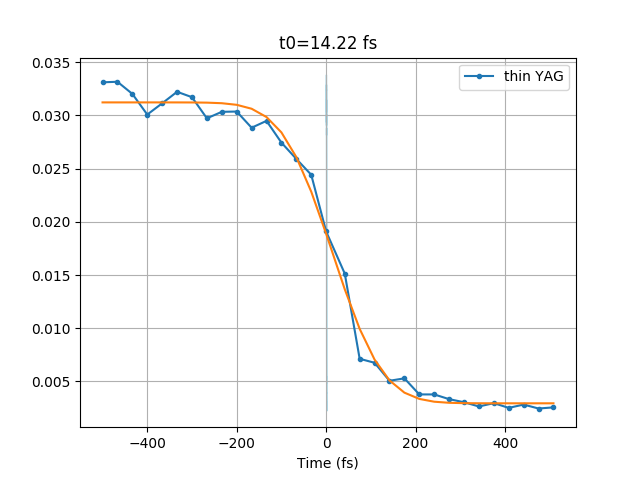

In [12]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Delay_ps_toFit*1000, Pump_probe_toFit, label="thin YAG",marker='.')
plt.plot(Delay_ps_toFit*1000, errfunc(Delay_ps_toFit,*parameters))

#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

plt.fill_between(Delay_ps_toFit, low_err, high_err, color='lightblue')
plt.title('t0=' + str(np.round(parameters[2], 5)*1000) + ' fs' )
plt.grid()
plt.xlabel("Time (fs)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')